In [1]:
%%capture
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm
from PIL import Image
from IPython.display import Image as ImagePy, display
import torch
import warnings
warnings.filterwarnings('ignore')
import h5py
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, preprocess = clip.load("RN101", device=device)
clip_model.eval() # per sicurezza

In [ ]:
#@title check embedding size
image = Image.fromarray(frame)
image = image.convert('RGB') if image.mode != 'RGB' else image
image = preprocess(image).to(device)
with torch.no_grad():
  emb = clip_model.encode_image(torch.stack([image]))
  print(emb.shape)
  print(emb.size())

torch.Size([1, 512])
torch.Size([1, 512])


In [3]:
#@title Modello CLIP Finetunato
%%capture
from torch.nn import functional as F
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(512, 64)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

class CustomCLIP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    model = clip_model

    self.encoder = model.visual.float()

    self.classifier = MLP() # Classifier

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.encoder(x)
    x = self.classifier(x)
    return x

net = CustomCLIP().to(device)
checkpoint = torch.load("/content/drive/MyDrive/TESI/CODICE/CLIP_Models/no_long_8_epochs")
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

In [3]:
#@title get_clip_embedding

def get_clip_embeddings(frames, finetuned_flag):
    if len(frames)!=10:
      print(f"WARNING: get_clip_embeddings received {len(frames)} frames!")

    # Convert the numpy array of frames to a list of PIL Images and convert to RGB if necessary
    images = [Image.fromarray(frame) for frame in frames]
    images = [image.convert('RGB') if image.mode != 'RGB' else image for image in images]
    image_inputs = torch.stack([preprocess(image) for image in images]).to(device)

    with torch.no_grad():
        if finetuned_flag: embeddings = net.encoder(image_inputs)
        else: embeddings = clip_model.encode_image(image_inputs)

    # Average the embeddings
    video_segment_embedding = embeddings.mean(dim=0)
    video_segment_embedding = torch.nn.functional.normalize(video_segment_embedding, p=2, dim=0) # normalize to help the MLP classifier later
    return video_segment_embedding.cpu()

In [4]:
#@title get_patch_embeddings

# I primi 9 Embedding sono le patch, il 10 è dell'immagine completa
def get_patch_embeddings(frames, finetuned_flag):
    if len(frames)!=10:
      print(f"WARNING: get_clip_embeddings received {len(frames)} frames!")

    # Convert the numpy array of frames to a list of PIL Images and convert to RGB if necessary
    images = [Image.fromarray(frame) for frame in frames]
    images = [image.convert('RGB') if image.mode != 'RGB' else image for image in images]

    # Divide each image into 9 non-overlapping patches
    patch_size = 224 // 3  # results in 74, the bottom&right-most 2 pixels will be lost
    patches = [[image.crop((i * patch_size, j * patch_size, (i + 1) * patch_size, (j + 1) * patch_size)) for i in range(3) for j in range(3)] for image in images]

    # Transpose the list of patches so that the same positions are together
    patches = list(map(list, zip(*patches)))

    # Flatten the list of patches
    patches_flat = [patch for image_patches in patches for patch in image_patches]

    # Add the original images at the end of the patches_flat list
    patches_flat += images

    image_inputs = torch.stack([preprocess(image) for image in patches_flat]).to(device)

    with torch.no_grad():
        if finetuned_flag: embeddings = net.encoder(image_inputs)
        else: embeddings = clip_model.encode_image(image_inputs)

    # Reshape and average the embeddings
    embeddings = embeddings.view(10, len(frames), -1)
    video_segment_embedding = embeddings.mean(dim=1)
    video_segment_embedding = torch.nn.functional.normalize(video_segment_embedding, p=2, dim=1) # normalize to help the MLP classifier later

    return video_segment_embedding.cpu()

## Generate Embeddings from Video and Txt

In [ ]:
#@title get_frames con CLIP preprocess


def get_frames(path, labels, add_width, add_height, move_right, move_lower):
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, labels.iloc[0]['framenum'])  # Set the starting frame
    progress_bar = tqdm(total=len(labels), position=0, leave=True)
    all_frames_speak = []
    all_frames_no_speak= []
    current_frames = []
    negative_frames = 0
    current_start_frame = labels.iloc[0]['framenum']
    current_label = labels.iloc[0]['speaking_status']
    frame_height = 360
    frame_width = 640
    try:
        for index, row in labels.iterrows():
            ret, frame = cap.read()

            if row.TLx < 0 or row.TLy < 0:
                negative_frames += 1
                if current_frames:
                    end_frame_num = labels.iloc[index-1]['framenum'] if index < len(labels) else current_start_frame
                    if current_label == 0:
                        all_frames_no_speak.append((np.array(current_frames), current_start_frame, end_frame_num))
                    else:
                        all_frames_speak.append((np.array(current_frames), current_start_frame, end_frame_num))
                current_frames = []
                current_start_frame = row['framenum']
                progress_bar.update(1)
                continue

            # Calculate the center of the box
            center_x = (row.TLx + row.width // 2) + move_right
            center_y = (row.TLy + row.width // 2) + move_lower

            # Calculate the new TLx and width
            half_width = max(0, (row.width + add_width) // 2)
            new_TLx = max(0, center_x - half_width)
            new_width = min(frame_width - new_TLx, row.width + add_width)

            # Calculate the new TLy and height
            half_height = max(0, (row.width + add_height) // 2)
            new_TLy = max(0, center_y - half_height)
            new_height = min(frame_height - new_TLy, row.width + add_height)

            # Crop the frame
            frame = frame[new_TLy : new_TLy + new_height, new_TLx : new_TLx + new_width]
            frame = frame[:, :, [2, 1, 0]]
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # lo fa già la riga sopra

            # -------------- CLIP PREPROCESS -----------------
            f = Image.fromarray(frame)
            f = f.convert('RGB') if f.mode != 'RGB' else f
            f = preprocess(f)

            # CLIP's preprocess function normalizes the image with the mean and std deviation
            # We need to reverse this process to display the image correctly
            unnormalize = transforms.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954, 1/0.26130258, 1/0.27577711))

            # Convert tensor to PIL Image
            img = transforms.ToPILImage()(unnormalize(f)).convert("RGB")
            img = np.array(img)
            #----------------------------------------------------

            if current_label == row.speaking_status:
                current_frames.append(img)
            else:
                end_frame_num = labels.iloc[index-1]['framenum'] if index < len(labels) else current_start_frame
                if current_label == 0:
                    all_frames_no_speak.append((np.array(current_frames), current_start_frame, end_frame_num))
                else:
                    all_frames_speak.append((np.array(current_frames), current_start_frame, end_frame_num))
                current_label = row.speaking_status
                current_frames = [img]
                current_start_frame = row['framenum']

            progress_bar.update(1)

        # check last cluster
        end_frame_num = labels.iloc[index]['framenum'] if index < len(labels) else current_start_frame
        if current_label == 0:
            all_frames_no_speak.append((np.array(current_frames), current_start_frame, end_frame_num))
        else:
            all_frames_speak.append((np.array(current_frames), current_start_frame, end_frame_num))

    finally:
        cap.release()
        cv2.destroyAllWindows()
        progress_bar.close()

    print(f"\n\nFRAME NEGATIVI {negative_frames}")
    print(f"FRAME SPEAK {len(all_frames_speak)}")
    print(f"FRAME NO SPEAK {len(all_frames_no_speak)}")
    return np.array(all_frames_speak), np.array(all_frames_no_speak)

In [ ]:
#@title interpolation function
def interpolation(traj, start_frame_num, target_frame_num):
    new_traj = []
    original_frame_counts = []
    frame_nums = []
    for i in range(0, len(traj), target_frame_num):
        chunk = traj[i:i+target_frame_num]
        original_frame_count = len(chunk)
        while len(chunk) < target_frame_num:
            num_frames_to_add = min(target_frame_num - len(chunk), len(traj) - i)
            chunk = np.concatenate((chunk, traj[i:i+num_frames_to_add]))
        new_traj.append(np.array(chunk))
        original_frame_counts.append(original_frame_count)
        frame_nums.append((start_frame_num + i, start_frame_num + i + original_frame_count - 1))
    return new_traj, original_frame_counts, frame_nums

In [ ]:
embeddings = np.load('/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/pretrained_visual_CLIP_crop.npy', allow_pickle=True).item()
len(embeddings)

13738

In [ ]:
embeddings['bell_142800_142809'][2].dtype

torch.float16

TOTAL FRAMES: 76
Start Frame: 152385
End Frame: 152460


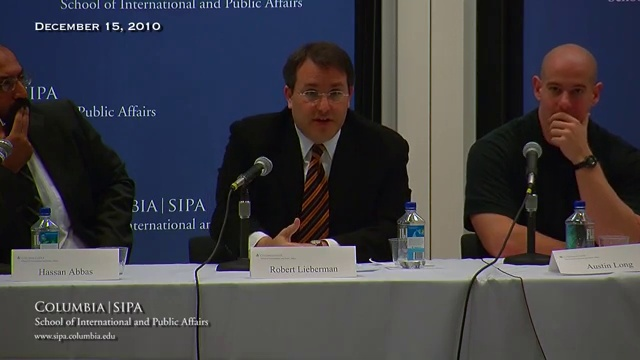

In [ ]:
col_names = ['framenum', 'TLx', 'TLy', 'width', 'speaking_status']

txt_path = '/content/drive/MyDrive/TESI/CODICE/Columbia Dataset/tracks_13_149670_153700/2.txt'

df = pd.read_csv(txt_path, sep='\t', header=None, names=col_names, index_col=False)
print(f'TOTAL FRAMES: {df.shape[0]}\nStart Frame: {df.iloc[0]["framenum"]}\nEnd Frame: {df.iloc[-1]["framenum"]}')
cap = cv2.VideoCapture("drive/MyDrive/TESI/CODICE/Columbia Dataset/Columbia 360.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, df.iloc[1]['framenum'])
ret, frame = cap.read()
cap.release()
cv2.imwrite('full_frame.jpg', frame)
ImagePy('full_frame.jpg')

SPEAKER: sick



100%|██████████| 1/1 [00:00<00:00, 75.20it/s]



FRAME NEGATIVI 0
FRAME SPEAK 0
FRAME NO SPEAK 1

SIZE: (224, 224, 3)


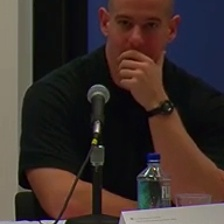

In [ ]:
# Controllo Ritaglio
speaker = 'sick' # bell   lieberman   long    sick   bollinger

track = txt_path.split('/')
track = track[-2]
track = track.split('_')
track = track[1]

print(f'SPEAKER: {speaker}\n')

Test_SPEAK, Test_NO_SPEAK = get_frames("drive/MyDrive/TESI/CODICE/Columbia Dataset/Columbia 360.mp4", df.iloc[[1]], 50,130,move_right=0, move_lower=40)
if len(Test_SPEAK)>0:
  cv2.imwrite('test.jpg', Test_SPEAK[0][0][0])
  print(f"\nSIZE: {Test_SPEAK[0][0][0].shape}")
  display(ImagePy('test.jpg'))
else:
  cv2.imwrite('test.jpg', Test_NO_SPEAK[0][0][0])
  print(f"\nSIZE: {Test_NO_SPEAK[0][0][0].shape}")
  display(ImagePy('test.jpg'))

In [ ]:
# Struttura: F_SPEAK[0] è il primo segmento di frames speak, F_SPEAK[0][0] è l'effettiva lista di frames, F_SPEAK[0][1] è il framenum iniziale
F_SPEAK, F_NO_SPEAK = get_frames("drive/MyDrive/TESI/CODICE/Columbia Dataset/Columbia 360.mp4", df, 50,130,move_right=0, move_lower=40)
print(f'SPEAKER: {speaker}')

100%|██████████| 76/76 [00:00<00:00, 82.74it/s]



FRAME NEGATIVI 0
FRAME SPEAK 0
FRAME NO SPEAK 1
SPEAKER: sick


In [ ]:
embeddings = {}

In [ ]:
#@title SAVE

count_before = len(embeddings)

if len(F_SPEAK)>0:
  for s in F_SPEAK: # s[0] list of frames, s[1] start framenum, s[2] end framenum
    interpolated_frames, original_frames, frame_nums = interpolation(s[0], s[1], 10)
    progress_bar = tqdm(total=len(interpolated_frames), position=0, leave=True)

    for ten_f, original_f, f_nums in zip(interpolated_frames,original_frames, frame_nums):

      embedding = get_clip_embeddings(ten_f)

      # Aggiungi al dizionario l'elemento (Speaker, Label, Embedding)
      embeddings[f'{speaker}_{f_nums[0]}_{f_nums[1]}'] = (speaker, 1, embedding, original_f)

      progress_bar.update(1)
  progress_bar.close()

if len(F_NO_SPEAK)>0:
  for s in F_NO_SPEAK: # s[0] list of frames, s[1] start framenum, s[2] end framenum
    interpolated_frames, original_frames, frame_nums = interpolation(s[0], s[1], 10)
    progress_bar = tqdm(total=len(interpolated_frames), position=0, leave=True)

    for ten_f, original_f, f_nums in zip(interpolated_frames,original_frames, frame_nums):

      embedding = get_clip_embeddings(ten_f)

      # Aggiungi al dizionario l'elemento (Speaker, Label, Embedding)
      embeddings[f'{speaker}_{f_nums[0]}_{f_nums[1]}'] = (speaker, 0, embedding, original_f)

      progress_bar.update(1)
  progress_bar.close()

count_after = len(embeddings)
print(f'\n\nTOT NEW ELEMENTS: {count_after-count_before} \nNew Length: {count_after}')

100%|██████████| 8/8 [01:04<00:00,  8.11s/it]



TOT NEW ELEMENTS: 8 
New Length: 8


In [ ]:
# Get the first key
key = next(reversed(embeddings))
print(f"Last Key: {key}")
print(embeddings['sick_25472_25481'][3])

Last Key: long_73413_73419
10


In [ ]:
check = {k for k, v in embeddings.items() if k.endswith("61800")}
print(check)

{'sick_61791_61800', 'long_61791_61800', 'bell_61791_61800'}


In [ ]:
print(len(embeddings))
np.save('/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/pretrained_CLIP_crop.npy', embeddings)

13738


## Generate Embeddings from HDF5 dataset

In [ ]:
!cp "/content/drive/MyDrive/TESI/CODICE/Columbia Dataset/Frames_labels_dataset/database.h5" "/content/dataset.h5"

In [5]:
dataset_path = "/content/drive/MyDrive/TESI/CODICE/Columbia Dataset/Frames_labels_dataset/database.h5"

In [ ]:
#@title Check Data
print("----------------------- FRAMES ---- LABELS")
with h5py.File(dataset_path, 'r') as f:
    tot_frames = 0
    tot_labels = 0
    for p in f.keys():
      person = f[p]
      group_f = person['frames'].attrs.get('data_length')
      group_l = person['labels'].attrs.get('data_length')

      tot_frames += group_f
      tot_labels += group_l

      print(f'Group {p}:      \t{group_f} \t\t{group_l}')

    print(f"TOTAL DATA------------- {tot_frames} --------- {tot_labels}")

----------------------- FRAMES ---- LABELS
Group bell:      	37422 		37422
Group bollinger:      	15080 		15080
Group lieberman:      	16400 		16400
Group long:      	29391 		29391
Group sick:      	38526 		38526
TOTAL DATA------------- 136819 --------- 136819


In [22]:
embeddings_dict = {}

In [2]:
embeddings_dict = np.load("/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/Finetuned_no_long_patches.npy",allow_pickle=True ).item()
len(embeddings_dict)

7609

In [10]:
#@title Generate Embeddings
with h5py.File(dataset_path, 'r') as f:
  #for speaker in ['bell','sick','long','lieberman','bollinger']:
  for speaker in ['bell']:
    print(speaker.upper())
    start_len = len(embeddings_dict)
    person = f[speaker]
    frames = person['frames']
    labels = person['labels']
    frame_index = 0
    progress_bar = tqdm(total=len(frames), position=0, leave=False)
    while frame_index < len(frames):
        current_label = labels[frame_index]
        current_frames = []
        original_frames_count = 0
        while len(current_frames) < 10 and frame_index < len(frames):
            if labels[frame_index] == current_label:
                current_frames.append(frames[frame_index])
                original_frames_count += 1
                frame_index += 1
            else:
                break
        while len(current_frames) < 10:
            current_frames += current_frames[:10 - len(current_frames)]
        embedding = get_clip_embeddings(np.array(current_frames), True)
        key = f"{speaker}_{frame_index - len(current_frames)}_{frame_index - 1}"
        embeddings_dict[key] = (speaker, current_label, embedding, original_frames_count)
        progress_bar.update(10)
    progress_bar.close()
    end_len = len(embeddings_dict)

    print(f"Nuovi aggiunti: {end_len-start_len} \t TOTALE: {end_len} \n------------------------------")

BELL


Nuovi aggiunti: 3751 	 TOTALE: 13732 
------------------------------


In [8]:
#@title Generate PATCH Embeddings
with h5py.File(dataset_path, 'r') as f:
  #for speaker in ['bell','sick','long','lieberman','bollinger']:
  for speaker in ['lieberman','bollinger']:
    print(speaker.upper())
    start_len = len(embeddings_dict)
    person = f[speaker]
    frames = person['frames']
    labels = person['labels']
    frame_index = 0
    progress_bar = tqdm(total=len(frames), position=0, leave=False)
    while frame_index < len(frames):
        current_label = labels[frame_index]
        current_frames = []
        original_frames_count = 0
        while len(current_frames) < 10 and frame_index < len(frames):
            if labels[frame_index] == current_label:
                current_frames.append(frames[frame_index])
                original_frames_count += 1
                frame_index += 1
            else:
                break
        while len(current_frames) < 10:
            current_frames += current_frames[:10 - len(current_frames)]
        embedding = get_patch_embeddings(np.array(current_frames), True)

        embedding = embedding.view(-1)  # flatten the tensor

        key = f"{speaker}_{frame_index - len(current_frames)}_{frame_index - 1}"
        embeddings_dict[key] = (speaker, current_label, embedding, original_frames_count)
        progress_bar.update(10)
    progress_bar.close()
    end_len = len(embeddings_dict)
    print(f"Nuovi aggiunti: {end_len-start_len} \t TOTALE: {end_len} \n------------------------------")

LIEBERMAN


Nuovi aggiunti: 1643 	 TOTALE: 12193 
------------------------------
BOLLINGER


Nuovi aggiunti: 1539 	 TOTALE: 13732 
------------------------------


In [9]:
np.save('/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/Finetuned_no_long_patches.npy', embeddings_dict)
len(embeddings_dict)

13732

In [ ]:
from google.colab import runtime
runtime.unassign()

## TEST EMBEDDINGS

In [13]:
#@title Load Embedding Dictionary
import numpy as np
import gc
import torch

#embeddings = np.load('/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/Finetuned_no_bollinger.npy', allow_pickle=True).item()

bell_files = []
bollinger_files = []
sick_files = []
long_files = []
lieberman_files = []

# Separate the embeddings based on the person's name
for key, (person, label, embedding, original_frames) in embeddings_dict.items():
    if person == 'bell':
        bell_files.append((embedding.float(), label, original_frames))
    elif person == 'sick':
        sick_files.append((embedding.float(), label, original_frames))
    elif person == 'long':
        long_files.append((embedding.float(), label, original_frames))
    elif person == 'bollinger':
        bollinger_files.append((embedding.float(), label, original_frames))
    elif person == 'lieberman':
        lieberman_files.append((embedding.float(), label, original_frames))



print(f"Bell files: {len(bell_files)}")
print(f"Sick files: {len(sick_files)}")
print(f"Long files: {len(long_files)}")
print(f"Bollinger files: {len(bollinger_files)}")
print(f"Lieberman files: {len(lieberman_files)}")
print(f"TOT FILES: {len(bell_files)+len(sick_files)+len(long_files)+len(bollinger_files)+len(lieberman_files)}")

Bell files: 3751
Sick files: 3858
Long files: 2941
Bollinger files: 1539
Lieberman files: 1643
TOT FILES: 13732


In [14]:
# Set Training Data
import random

train_val_data = (
               bell_files+
               sick_files+
               #long_files+
               bollinger_files+
               lieberman_files
               )

In [15]:
#@title model for classification
import torch
from torch import nn
from torch.nn import functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        torch.manual_seed(0)
        self.fc1 = torch.nn.Linear(512, 64)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [16]:
#@title Custom Training con Validation
from sklearn.metrics import f1_score
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

def custom_training(wandb_flag, learning_rate, weight_decay, batch_size, epochs, step_size=15, gamma=0.1):

  if wandb_flag:
    wandb.init(
      settings=wandb.Settings(console="off"),
      project="MLP Training ResNet Pretrained Embeddings",
      name="no bell grid-search",
      config={
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      'weight_decay': weight_decay}
    )

  set_seed(42)

  train_data, val_data = train_test_split(train_val_data, test_size=0.2)

  train_labels = [label for embedding, label, original_f in train_data]
  class_weights_train = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

  train_data_tensors = [(embedding.clone().detach(), torch.tensor(label)) for embedding, label, original_f in train_data]
  val_data_tensors = [(embedding.clone().detach(), torch.tensor(label)) for embedding, label, original_f in val_data]

  model = MyModel().cuda()
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
  criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights_train)[1].cuda())
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  for epoch in range(epochs):
      random.shuffle(train_data_tensors)
      correct_predictions = 0
      total_predictions = 0
      total_loss = 0
      for i in range(0, len(train_data_tensors), batch_size):
          batch = train_data_tensors[i:i+batch_size]
          X = torch.stack([embedding for embedding, label in batch]).cuda()
          y = torch.stack([label for embedding, label in batch]).cuda()

          optimizer.zero_grad()
          outputs = model(X.float()).squeeze()
          loss = criterion(outputs, y.float())
          loss.backward()

          probabilities = torch.sigmoid(outputs)
          predictions = (probabilities > 0.5).float()
          correct_predictions += (predictions == y).sum().item()
          total_predictions += y.size(0)
          total_loss += loss.item()

          optimizer.step()

      #scheduler.step()

      train_accuracy = correct_predictions / total_predictions
      train_loss = total_loss / total_predictions

      # Validation
      model.eval()  # set the model to evaluation mode
      with torch.no_grad():  # disable gradient calculation
          val_loss_total = 0
          num_batches = 0
          correct_predictions_val = 0
          total_predictions_val = 0
          all_predictions = []
          all_labels = []
          for i in range(0, len(val_data_tensors), batch_size):
              batch = val_data_tensors[i:i+batch_size]
              X_val = torch.stack([embedding for embedding, label in batch]).cuda()
              y_val = torch.stack([label for embedding, label in batch]).cuda()

              outputs_val = model(X_val.float()).squeeze()
              val_loss = criterion(outputs_val, y_val.float())
              val_loss_total += val_loss.item()
              num_batches += 1


              probabilities = torch.sigmoid(outputs_val)
              predictions_val = (probabilities > 0.5).float()
              all_predictions.extend(predictions_val.cpu().numpy())
              all_labels.extend(y_val.cpu().numpy())
              total_predictions_val += y_val.size(0)
              correct_predictions_val += (predictions_val == y_val).sum().item()

          val_loss = val_loss_total / total_predictions_val
          val_accuracy = correct_predictions_val / total_predictions_val
          f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
          f1_macro = f1_score(all_labels, all_predictions, average='macro')


      if wandb_flag:
        wandb.log({"Train loss": train_loss, "Train Accuracy": train_accuracy,
                "Val loss": val_loss, "Val Accuracy": val_accuracy,})

  if wandb_flag:  wandb.finish()
  return model, f1_macro, f1_weighted

In [17]:
#@title RANDOM SEARCH
from sklearn.model_selection import ParameterSampler
import numpy as np

# 17 min per search
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [20, 30],
}


# Create the parameter grid
n_iter_search = 22  # Number of parameter settings that are sampled.
random_search = ParameterSampler(param_grid, n_iter=n_iter_search, random_state=0)

best_macro = 0
best_weighted = 0
best_macro_params = None
best_weight_params = None

for num, params in enumerate(random_search):
  print(f"--- {num} ---")
  model, macro, weighted  = custom_training(False, **params)
  if macro > best_macro:
      best_macro = macro
      best_macro_params = params
      print(f"Found new best F1 MACRO: {macro} \t {params}")
  if weighted > best_weighted:
      best_weighted = weighted
      best_weight_params = params
      print(f"Found new best F1 WEIGHTED: {weighted} \t {params}")

print(f'\nbest F1 WEIGHTED: {best_weighted} with parameters: {best_weight_params}')
print(f'Found new best F1 MACRO: {best_macro} with parameters: {best_macro_params}')

--- 0 ---
Found new best F1 MACRO: 0.9817239972056486 	 {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 64}
Found new best F1 WEIGHTED: 0.9823764790030389 	 {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 64}
--- 1 ---
Found new best F1 MACRO: 0.983683465544252 	 {'weight_decay': 0.01, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 32}
Found new best F1 WEIGHTED: 0.9842491471492985 	 {'weight_decay': 0.01, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 32}
--- 2 ---
Found new best F1 MACRO: 0.9841661968181272 	 {'weight_decay': 0.01, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 64}
Found new best F1 WEIGHTED: 0.9847137803558981 	 {'weight_decay': 0.01, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 64}
--- 3 ---
--- 4 ---
--- 5 ---
--- 6 ---
--- 7 ---
--- 8 ---
--- 9 ---
--- 10 ---
--- 11 ---
--- 12 ---
--- 13 ---
--- 14 ---
Found new best F1 MACRO: 0.984177449217467 	 {'weight_decay': 0.001, 'learning_

In [18]:
model, _,_ = custom_training(wandb_flag = False, **best_macro_params)

In [19]:
test_data_tensors = [(embedding.clone().detach(), torch.tensor(label), torch.tensor(original_frames))
                    for embedding, label, original_frames in long_files]

In [20]:
#@title Test Code
from sklearn.metrics import f1_score

criterion = torch.nn.BCEWithLogitsLoss()

model.eval()

with torch.no_grad():
    test_loss_total = 0
    tot = 0
    correct_predictions_test = 0
    total_predictions_test = 0
    all_predictions = []
    all_labels = []
    for i in range(0, len(test_data_tensors)):
        embedding, y_test, original_frames = test_data_tensors[i]
        X_test = embedding.unsqueeze(0).cuda()  # Add a batch dimension
        y_test = y_test.cuda()

        outputs_test = model(X_test.float()).squeeze()
        test_loss = criterion(outputs_test, y_test.float())
        test_loss_total += test_loss.item()
        tot += 1

        outputs_prob = torch.sigmoid(outputs_test)
        prediction_test = (outputs_prob > 0.5).float().cpu()  # prediction for each embedding

        all_predictions.extend([prediction_test] * original_frames.item())
        all_labels.extend([y_test.item()] * original_frames.item())
        total_predictions_test += original_frames.item()
        correct_predictions_test += (prediction_test == y_test.item()) * original_frames.item()
        # all_predictions.extend([prediction_test])
        # all_labels.extend([y_test.item()])
        # total_predictions_test += 1
        # correct_predictions_test += (prediction_test == y_test.item())

    test_accuracy = (correct_predictions_test / total_predictions_test).item()
    test_loss = test_loss_total / tot
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
    f1_macro = f1_score(all_labels, all_predictions, average='macro')

print("Test loss: ", round(test_loss,4))
print("Test Accuracy: ", round(test_accuracy,4))
print("F1 Weighted: ", round(f1_weighted,4))
print("F1 Macro: ", round(f1_macro,4))

Test loss:  0.5692
Test Accuracy:  0.803
F1 Weighted:  0.8024
F1 Macro:  0.8029
